In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [4]:
def plot_training(history, marker=None):
    # put everything on cpu
    for key, value in history.items():
        history[key] = [element.cpu() if isinstance(element, torch.Tensor) else element for element in value]

    plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training loss')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_loss'] + history['val_loss'])
        y_max = max(history['train_loss'] + history['val_loss'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training metric')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_acc'] + history['val_acc'])
        y_max = max(history['train_acc'] + history['val_acc'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.show()

In [17]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, modelNum, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    noOfBatches = len(iterator)
    train_first = int(noOfBatches / 2)

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            if modelNum == "first" and i >= train_first:
                continue
            elif modelNum == "second" and i < train_first:
                continue
            
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            if modelNum == "first":
                epoch_acc += accuracy / train_first
            elif modelNum == "second":
                epoch_acc += accuracy / (noOfBatches - train_first)
                
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / train_first, val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / train_first:.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}, \
              Learning Rate : {optimizer.param_groups[0]['lr'] :.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
# data = pd.concat([pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1'),
#                   pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')])
data = pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')
# convert string label to binary (int) label (spam:1, non-spam:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == "positive"))

# train, test, val split
train, valid, test = loader.make_dataset(data)
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=512,
                                                     device=device)
   

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)


dataset initializing start
Length of data after first step of preprocessing:  35832
Tokenizing the data...


c:\Users\atace\OneDrive\Desktop\ETH\9.Semester\Deep Learning\project\Exploring-Model-Fusion-with-Optimal-Transport-on-Transformers\dataloader.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["len"] = data.iloc[:, 0].apply(lambda x : len(self.tokenize(x)))


Length of the data :  29544
0
review       [[CLS], one, of, the, many, silent, comedies, ...
sentiment                                                    0
len                                                        186
Name: 46539, dtype: object


100%|██████████| 2955/2955 [00:00<00:00, 7174.52it/s] 


dataset initializing done
Vocabulary Size :  23050


In [30]:
embedding = torch.nn.Embedding(voc_size, 16)

# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_22320/506800822.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:40<00:00,  1.15it/s]
C:\Users\atace\AppData\Local\Temp/ipykernel_22320/506800822.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.8945               Validation Loss: 0.7733               Train acc: 0.5073,               Val acc: 0.5180,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.18it/s]


Epoch: 2  Train Loss: 0.9039               Validation Loss: 0.9926               Train acc: 0.5088,               Val acc: 0.4978,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:55<00:00,  1.17s/it]


Epoch: 3  Train Loss: 0.8565               Validation Loss: 1.0001               Train acc: 0.5217,               Val acc: 0.4956,               Learning Rate : 0.0020


100%|██████████| 47/47 [01:00<00:00,  1.29s/it]


Epoch: 4  Train Loss: 0.8175               Validation Loss: 0.8384               Train acc: 0.5305,               Val acc: 0.5003,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.05it/s]


Epoch: 5  Train Loss: 0.7766               Validation Loss: 0.7666               Train acc: 0.5445,               Val acc: 0.5244,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.18it/s]


Epoch: 6  Train Loss: 0.6958               Validation Loss: 0.7210               Train acc: 0.5805,               Val acc: 0.5483,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.18it/s]


Epoch: 7  Train Loss: 0.6668               Validation Loss: 0.7743               Train acc: 0.6103,               Val acc: 0.5551,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


Epoch: 8  Train Loss: 0.6354               Validation Loss: 0.6942               Train acc: 0.6389,               Val acc: 0.5904,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


Epoch: 9  Train Loss: 0.5996               Validation Loss: 0.6835               Train acc: 0.6690,               Val acc: 0.6189,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.06it/s]


Epoch: 10  Train Loss: 0.5648               Validation Loss: 0.7789               Train acc: 0.7057,               Val acc: 0.5947,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.07it/s]


Epoch: 11  Train Loss: 0.5321               Validation Loss: 0.5950               Train acc: 0.7307,               Val acc: 0.7042,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:42<00:00,  1.10it/s]


Epoch: 12  Train Loss: 0.4817               Validation Loss: 0.6023               Train acc: 0.7697,               Val acc: 0.7107,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:42<00:00,  1.10it/s]


Epoch: 13  Train Loss: 0.4382               Validation Loss: 0.5467               Train acc: 0.7956,               Val acc: 0.7427,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.19it/s]


Epoch: 14  Train Loss: 0.3982               Validation Loss: 0.5636               Train acc: 0.8190,               Val acc: 0.7359,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.19it/s]


Epoch: 15  Train Loss: 0.3595               Validation Loss: 0.5063               Train acc: 0.8395,               Val acc: 0.7726,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:42<00:00,  1.10it/s]


Epoch: 16  Train Loss: 0.3501               Validation Loss: 0.5100               Train acc: 0.8440,               Val acc: 0.7826,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:42<00:00,  1.11it/s]


Epoch: 17  Train Loss: 0.3022               Validation Loss: 0.4903               Train acc: 0.8684,               Val acc: 0.7916,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:45<00:00,  1.03it/s]


Epoch: 18  Train Loss: 0.2703               Validation Loss: 0.4936               Train acc: 0.8892,               Val acc: 0.7961,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:43<00:00,  1.07it/s]


Epoch: 19  Train Loss: 0.2543               Validation Loss: 0.4953               Train acc: 0.8961,               Val acc: 0.8053,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.05it/s]


Epoch: 20  Train Loss: 0.2399               Validation Loss: 0.6454               Train acc: 0.8998,               Val acc: 0.7616,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.06it/s]


Epoch: 21  Train Loss: 0.2445               Validation Loss: 0.5124               Train acc: 0.8989,               Val acc: 0.8032,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:46<00:00,  1.01it/s]


Epoch: 22  Train Loss: 0.2094               Validation Loss: 0.4856               Train acc: 0.9164,               Val acc: 0.8144,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.05it/s]


Epoch: 23  Train Loss: 0.2024               Validation Loss: 0.5475               Train acc: 0.9199,               Val acc: 0.8004,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


Epoch: 24  Train Loss: 0.1729               Validation Loss: 0.5030               Train acc: 0.9350,               Val acc: 0.8127,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.05it/s]


Epoch: 25  Train Loss: 0.1583               Validation Loss: 0.5016               Train acc: 0.9423,               Val acc: 0.8210,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


Epoch: 26  Train Loss: 0.1386               Validation Loss: 0.5180               Train acc: 0.9523,               Val acc: 0.8187,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.19it/s]


Epoch: 27  Train Loss: 0.1269               Validation Loss: 0.5220               Train acc: 0.9563,               Val acc: 0.8256,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


Epoch: 28  Train Loss: 0.1109               Validation Loss: 0.5217               Train acc: 0.9631,               Val acc: 0.8262,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:39<00:00,  1.18it/s]


Epoch: 29  Train Loss: 0.0924               Validation Loss: 0.5272               Train acc: 0.9703,               Val acc: 0.8293,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:37<00:00,  1.24it/s]


Epoch: 30  Train Loss: 0.0924               Validation Loss: 0.5288               Train acc: 0.9710,               Val acc: 0.8277,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:38<00:00,  1.22it/s]


Epoch: 31  Train Loss: 0.0906               Validation Loss: 0.5319               Train acc: 0.9716,               Val acc: 0.8285,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:45<00:00,  1.03it/s]


Epoch: 32  Train Loss: 0.0870               Validation Loss: 0.5341               Train acc: 0.9744,               Val acc: 0.8284,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


Epoch: 33  Train Loss: 0.0898               Validation Loss: 0.5304               Train acc: 0.9719,               Val acc: 0.8313,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:41<00:00,  1.12it/s]


Epoch: 34  Train Loss: 0.0861               Validation Loss: 0.5377               Train acc: 0.9721,               Val acc: 0.8285,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


Epoch: 35  Train Loss: 0.0821               Validation Loss: 0.5335               Train acc: 0.9750,               Val acc: 0.8303,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


Epoch: 36  Train Loss: 0.0827               Validation Loss: 0.5327               Train acc: 0.9752,               Val acc: 0.8315,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:44<00:00,  1.06it/s]


Epoch: 37  Train Loss: 0.0805               Validation Loss: 0.5325               Train acc: 0.9770,               Val acc: 0.8315,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:45<00:00,  1.03it/s]


Epoch: 38  Train Loss: 0.0771               Validation Loss: 0.5326               Train acc: 0.9760,               Val acc: 0.8315,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


Epoch: 39  Train Loss: 0.0819               Validation Loss: 0.5413               Train acc: 0.9767,               Val acc: 0.8286,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:42<00:00,  1.10it/s]


Epoch: 40  Train Loss: 0.0801               Validation Loss: 0.5336               Train acc: 0.9771,               Val acc: 0.8306,               Learning Rate : 0.0000


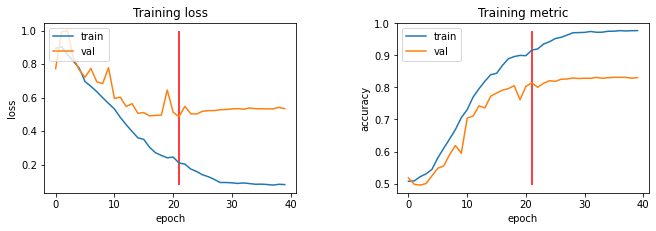

Wall time: 32min 8s


In [31]:
%%time
# train model A
modelA = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelA = modelA.to(device) # put on CPU/GPU

optA = torch.optim.Adam(modelA.parameters(), lr=0.002)
loss_fnA = nn.CrossEntropyLoss()


epochs = 40

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            modelNum = "first",
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA_IMDB_256_parallelization')

# save history
with open('./Models/history_modelA_IMDB_256_parallelization.txt', 'w') as dat:
    dat.write(str(historyA))

In [32]:
from copy import deepcopy
embeddingB = nn.Embedding.from_pretrained(deepcopy(best_modelA['encoder.emb.tok_emb.embedding.weight']))
embeddingB.weight.requires_grad = True

 36%|███▌      | 17/47 [00:00<00:00, 168.26it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_22320/506800822.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:44<00:00,  1.06it/s] 
C:\Users\atace\AppData\Local\Temp/ipykernel_22320/506800822.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 1.0941               Validation Loss: 0.7222               Train acc: 0.5175,               Val acc: 0.5675,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:47<00:00,  1.02s/it] 


Epoch: 2  Train Loss: 0.6045               Validation Loss: 0.6242               Train acc: 0.6849,               Val acc: 0.6598,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:46<00:00,  1.01it/s]


Epoch: 3  Train Loss: 0.4064               Validation Loss: 0.4696               Train acc: 0.8164,               Val acc: 0.7757,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.07it/s] 


Epoch: 4  Train Loss: 0.3089               Validation Loss: 0.4466               Train acc: 0.8687,               Val acc: 0.8036,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.05it/s] 


Epoch: 5  Train Loss: 0.2531               Validation Loss: 0.4404               Train acc: 0.8940,               Val acc: 0.8141,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.06it/s] 


Epoch: 6  Train Loss: 0.2173               Validation Loss: 0.4232               Train acc: 0.9146,               Val acc: 0.8264,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:47<00:00,  1.01s/it] 


Epoch: 7  Train Loss: 0.1688               Validation Loss: 0.4130               Train acc: 0.9385,               Val acc: 0.8440,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.06it/s] 


Epoch: 8  Train Loss: 0.1571               Validation Loss: 0.4155               Train acc: 0.9440,               Val acc: 0.8422,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:47<00:00,  1.01s/it] 


Epoch: 9  Train Loss: 0.1219               Validation Loss: 0.4644               Train acc: 0.9588,               Val acc: 0.8432,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:49<00:00,  1.05s/it] 


Epoch: 10  Train Loss: 0.1120               Validation Loss: 0.4491               Train acc: 0.9622,               Val acc: 0.8502,               Learning Rate : 0.0020


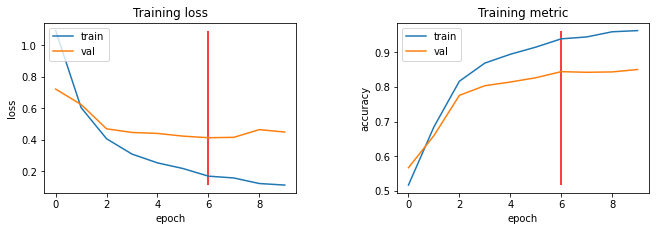

Wall time: 8min 33s


In [33]:
%%time
# train model B
modelB = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelB = modelB.to(device) # put on CPU/GPU

optB = torch.optim.Adam(modelB.parameters(), lr=0.002)
loss_fnB = nn.CrossEntropyLoss()


epochs = 10

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            modelNum="second",
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelB, './Models/modelB_IMDB_256_parallelization')

# save history
with open('./Models/historymodelB_IMDB_256_parallelization.txt', 'w') as dat:
    dat.write(str(historyB))

In [34]:
torch.save(embeddingB, "Models\embeddingB_16_trained_parallelization.pt")
torch.save(nn.Embedding.from_pretrained(best_modelA['encoder.emb.tok_emb.embedding.weight']), "Models\embeddingA_16_trained_parallelization.pt")

# Model fusion

### Definitions

In [ ]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [ ]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [ ]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [ ]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [ ]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

### Fusion

Vanilla fusion

In [ ]:
model_fusion = vanilla_fusion(modelA, modelB)

Optimal transport

In [ ]:
model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                               enc_voc_size = voc_size,
                               max_len = 256,
                               d_model = 512,
                               ffn_hidden = 2048,
                               n_head = 1,
                               n_layers = 1,
                               drop_prob = 0.1,
                               device = device)

model_fusion.load_state_dict(torch.load('./Models/model_fusion_OT_pre_retraining'))

### Test fusion

Randomly initialiized model for comparison

In [ ]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

Fusion model

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

In [ ]:
model_name = 'model_fusion_OT_post_retraining'

In [ ]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 200
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [ ]:
# save model
torch.save(best_model_fusion, f'./Models/{model_name}')

# save history
with open(f'./Models/history_{model_name}.txt', 'w') as dat:
    dat.write(str(history_fusion))

In [ ]:
# load best model (current model is trained on full epochs)
model_fusion.load_state_dict(best_model_fusion)

### Test fusion (after retraining)

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)